In [ ]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Max number of words in a sentence:  41
Number of unqiue words:  1545
Epoch 1/10
142/142 [==============================] - 13s 73ms/step - loss: 0.2710 - accuracy: 0.8871 - val_loss: 0.0636 - val_accuracy: 0.9850
Epoch 2/10
142/142 [==============================] - 7s 49ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0410 - val_accuracy: 0.9877
Epoch 3/10
142/142 [==============================] - 8s 58ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.0462 - val_accuracy: 0.9841
Epoch 4/10
142/142 [==============================] - 7s 46ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0450 - val_accuracy: 0.9824
Epoch 5/10
142/142 [==============================] - 7s 51ms/step - loss: 0.0108 - accuracy: 0.9960 - val_loss: 0.0580 - val_accuracy: 0.9806
Epoch 6/10
142/142 [==============================] - 7s 50ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0214 - val_accuracy: 0.9903
Epoch 7/10
142/142 [==============================] - 7s 47ms/step - los

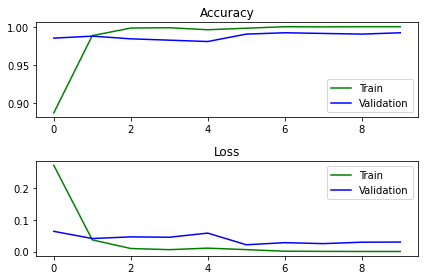

36/36 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9921
Test score: 0.030, accuracy: 0.992
1/1 [==============================] - 0s 218ms/step
1 - 1 - the da vinci code was absolutely awesome !
1/1 [==============================] - 0s 20ms/step
0 - 0 - and better .. -we all know da vinci code is bogus and inaccurate .
1/1 [==============================] - 0s 18ms/step
0 - 1 - `` im sick of books right now but i must say da vinci code was awesome .. ''
1/1 [==============================] - 0s 20ms/step
0 - 0 - da vinci code sucked ..
1/1 [==============================] - 0s 19ms/step
0 - 0 - we went to see brokeback mountain-which was kinda horrible lol ...


In [ ]:
x_train =train['sentence']
y_train =train['label']


vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(train.sentence)
x_test = vectorizer.transform(test.sentence)


word_freq = pd.DataFrame({'Word': vectorizer.get_feature_names(), 'Count': x_train.toarray().sum(axis=0)})
word_freq['Frequency'] = word_freq['Count'] / word_freq['Count'].sum()

word_freq_sort = word_freq.sort_values(by='Frequency', ascending=False)
word_freq_sort.head(10)


maxlen = 0
word_freqs = collections.Counter()
num_recs = 0


f = open("/content/train.csv", "rb")
for line in f:
    sentence = str(line).split(",")[0]
    words = nltk.word_tokenize(sentence.encode().decode("ascii", "ignore").lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
f.close()
print("Max number of words in a sentence: ", maxlen)
print("Number of unqiue words: ", len(word_freqs))


MAX_FEATURES = 1500
MAX_SENTENCE_LENGTH = 40
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

X = np.empty((num_recs, ), dtype=list)
Xt = []
y = np.zeros((num_recs, ))
i = 0

f = open("/content/train.csv", "r")
next(f)
fixed = []
for line in f:
    line_arr = line.split(",")
    if len(line_arr) > 2:
        line_arr[:len(line_arr)-1] = ["".join(line_arr[:len(line_arr)-1])]
        fixed.append(line_arr)
    else:
        fixed.append(line_arr)

for fline in fixed:
        sentence = fline[0]
        label = int(fline[1])
        words = nltk.word_tokenize(sentence.encode().decode("ascii", "ignore").lower())
        seqs = []
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1
f.close()

# Convert every occurence of None to an empty list

for i in range(0,X.shape[0]):
    if X[i] == None:
        X[i] = ()

X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)


# Get shape of X
X.shape


# Splitting our data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))


# Plot loss and accuracy values over time
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


score, acc = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(X_test))
    xtest = X_test[idx].reshape(1, 40)
    ylabel = Y_test[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f - %d - %s" % (ypred, ylabel, sent))

